# Federated Learning with HV Circuit Breaker Maintenance Data - Advanced

## Step 1: Install Required Packages

In [1]:
%pip install tensorflow tensorflow_federated pandas openpyxl scikit-learn matplotlib

## Step 2: Import required packages

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Importing custom functions
import breaker_advanced_functions as baf

# Step 3: Data Loading and Preprocessing

In [3]:
# Load data
df = pd.read_excel("HV_Circuit_Breaker_Maintenance_Data.xlsx", sheet_name='Sheet1')

# Clean and encode data
df = df.dropna(thresh=len(df) * 0.5, axis=1).dropna()
df = pd.get_dummies(df, columns=['Breaker_status', 'Heater_status', 'Last_trip_coil_energized'])

# Extract labels and scale features
y = df['Maintenance_required']
X = df.drop(columns=['Maintenance_required', 'Product_variant'])  # Drop 'Product_variant'

scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Final combined dataset for training
# Note: 'Product_variant' is not included in the final dataset as per the original code
df_final = X_scaled.copy()
df_final['Maintenance_required'] = y.values

# Step 4: Create Dirichlet Non-IID Client Partition and run comparisons for FedAvg and FedAvg with Momentum

Round 1: Accuracy=0.8025
Round 2: Accuracy=0.8035
Round 3: Accuracy=0.7960
Round 4: Accuracy=0.8105
Round 5: Accuracy=0.8175
Round 6: Accuracy=0.8285
Round 7: Accuracy=0.8405
Round 8: Accuracy=0.8405
Round 9: Accuracy=0.8465
Round 10: Accuracy=0.8550
Round 11: Accuracy=0.8590
Round 12: Accuracy=0.8600
Round 13: Accuracy=0.8670
Round 14: Accuracy=0.8695
Round 15: Accuracy=0.8705
Round 16: Accuracy=0.8820
Round 17: Accuracy=0.8815
Round 18: Accuracy=0.8775
Round 19: Accuracy=0.8895
Round 20: Accuracy=0.8970
Round 1: Accuracy=0.8825
Round 2: Accuracy=0.6395
Round 3: Accuracy=0.6520
Round 4: Accuracy=0.6895
Round 5: Accuracy=0.6995
Round 6: Accuracy=0.7065
Round 7: Accuracy=0.7180
Round 8: Accuracy=0.7165
Round 9: Accuracy=0.7215
Round 10: Accuracy=0.7230
Round 11: Accuracy=0.7325
Round 12: Accuracy=0.7490
Round 13: Accuracy=0.7555
Round 14: Accuracy=0.7540
Round 15: Accuracy=0.7600
Round 16: Accuracy=0.7560
Round 17: Accuracy=0.7695
Round 18: Accuracy=0.7690
Round 19: Accuracy=0.7940
Roun

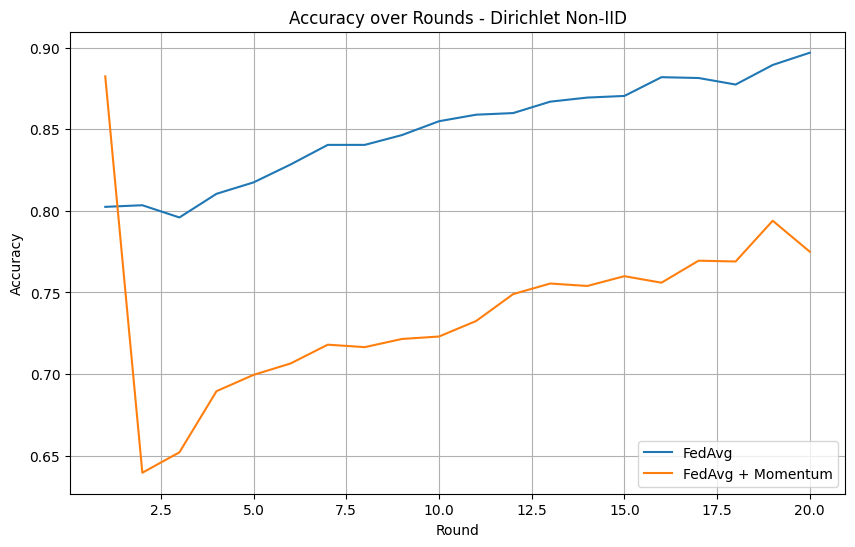

In [4]:
# Create TFF dataset
dirichlet_clients = baf.create_dirichlet_non_iid(df_final, num_clients=5, alpha=0.5, label_col='Maintenance_required')
# Compare on Dirichlet Non-IID data
baf.compare_algorithms(dirichlet_clients, "Dirichlet Non-IID")

# Step 5: Create Feature Skew Non-IID Client Partition and run comparisons for FedAvg and FedAvg with Momentum

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Round 1: Accuracy=0.5660
Round 2: Accuracy=0.6315
Round 3: Accuracy=0.6530
Round 4: Accuracy=0.6550
Round 5: Accuracy=0.6590
Round 6: Accuracy=0.6585
Round 7: Accuracy=0.6670
Round 8: Accuracy=0.6670
Round 9: Accuracy=0.6750
Round 10: Accuracy=0.6795
Round 11: Accuracy=0.6770
Round 12: Accuracy=0.6865
Round 13: Accuracy=0.6935
Round 14: Accuracy=0.6960
Round 15: Accuracy=0.7000
Round 16: Accuracy=0.7095
Round 17: Accuracy=0.7130
Round 18: Accuracy=0.7205
Round 19: Accuracy=0.7195
Round 20: Accuracy=0.7250
Round 1: Accuracy=0.6655
Round 2: Accuracy=0.6760
Round 3: Accuracy=0.6895
Round 4: Accuracy=0.6985
Round 5: Accuracy=0.7155
Round 6: Accuracy=0.7250
Round 7: Accuracy=0.7430
Round 8: Accuracy=0.7560
Round 9: Accuracy=0.7535
Round 10: Accuracy=0.7680
Round 11: Accuracy=0.7730
Round 12: Accuracy=0.7765
Round 13: Accuracy=0.7810
Round 14: Accuracy=0.7870
Round 15: Accuracy=0.7940
Round 16: Accuracy=0.7905
Round 17: Accuracy=0.8010
Round 18: Accuracy=0.7905
Round 19: Accuracy=0.8015
Roun

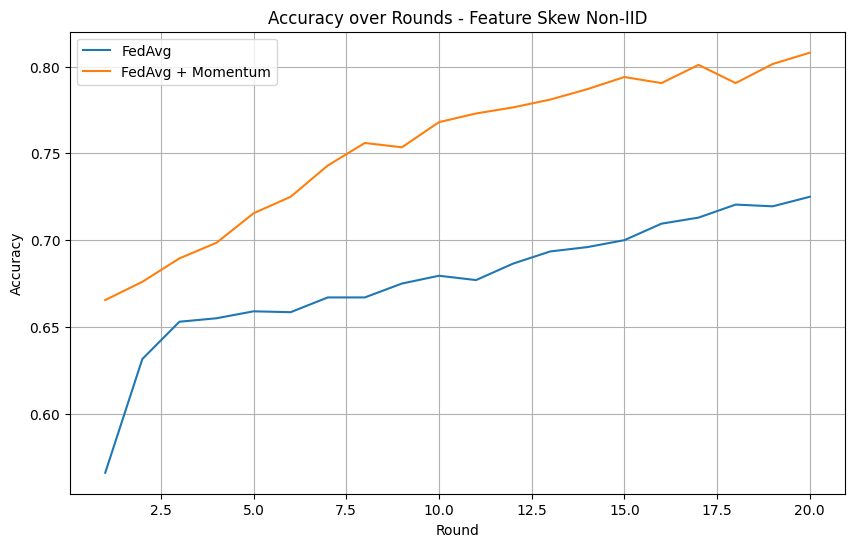

In [5]:
# Create IID dataset
feature_skew_clients = baf.create_feature_skew_non_iid(df_final, num_clients=5, feature='SF6_density', label_col='Maintenance_required')
# Compare on Feature Skew Non-IID data
baf.compare_algorithms(feature_skew_clients, "Feature Skew Non-IID")

# Step 6: Compare All Four Federated Algorithms

Instructions for updating:
Colocations handled automatically by placer.
/usr/local/lib/python3.11/dist-packages/tensorflow_federated/python/learning/models/keras_utils.py:201: UserWarning: Batch Normalization contains non-trainable variables that won't be updated during the training. Consider using Group Normalization instead.
  warnings.warn(


Round 1: Accuracy=0.6140
Round 2: Accuracy=0.6550
Round 3: Accuracy=0.6665
Round 4: Accuracy=0.6690
Round 5: Accuracy=0.6715
Round 6: Accuracy=0.6780
Round 7: Accuracy=0.6815
Round 8: Accuracy=0.6905
Round 9: Accuracy=0.6990
Round 10: Accuracy=0.6960
Round 11: Accuracy=0.7055
Round 12: Accuracy=0.7040
Round 13: Accuracy=0.7095
Round 14: Accuracy=0.7175
Round 15: Accuracy=0.7215
Round 16: Accuracy=0.7245
Round 17: Accuracy=0.7315
Round 18: Accuracy=0.7350
Round 19: Accuracy=0.7380
Round 20: Accuracy=0.7400
Round 1: Accuracy=0.6705
Round 2: Accuracy=0.6730
Round 3: Accuracy=0.6865
Round 4: Accuracy=0.6930
Round 5: Accuracy=0.7025
Round 6: Accuracy=0.7255
Round 7: Accuracy=0.7355
Round 8: Accuracy=0.7465
Round 9: Accuracy=0.7660
Round 10: Accuracy=0.7690
Round 11: Accuracy=0.7850
Round 12: Accuracy=0.7830
Round 13: Accuracy=0.7845
Round 14: Accuracy=0.7875
Round 15: Accuracy=0.7895
Round 16: Accuracy=0.7895
Round 17: Accuracy=0.8040
Round 18: Accuracy=0.7945
Round 19: Accuracy=0.7990
Roun

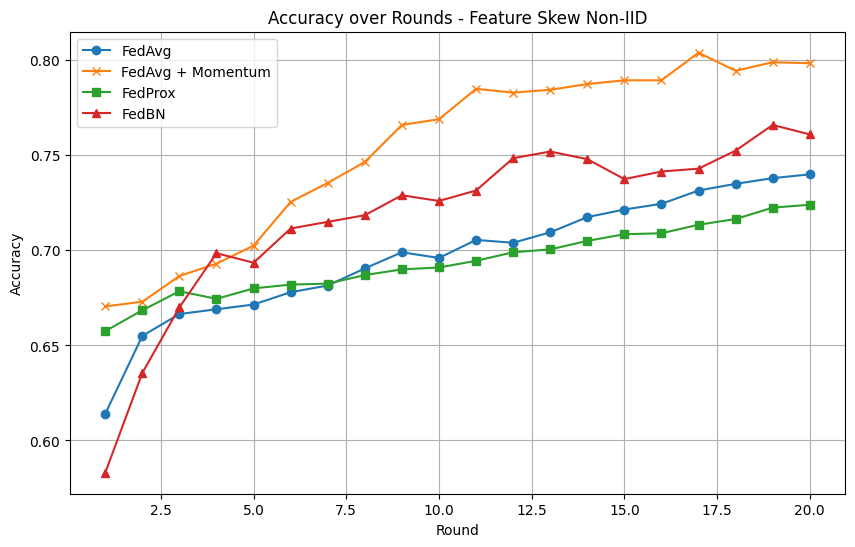

In [6]:
# For Feature Skew Non-IID data, we can also compare all algorithms
# using the compare_all_algorithms function
baf.compare_all_algorithms(feature_skew_clients, "Feature Skew Non-IID", num_rounds=20)